In [1]:
import os
import tarfile
import urllib
import numpy as np
import pickle
import pandas as pd
import datetime
import numpy as np

In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
X_PATH = '../datasets/Xtrain.pkl';
Y_PATH = '../datasets/Ytrain.pkl';

In [3]:
def load_data(path):
    return pd.read_pickle(path)

In [4]:
x_training = load_data(X_PATH)
y_labels = load_data(Y_PATH)

np.shape(x_training)

(60000, 28, 28)

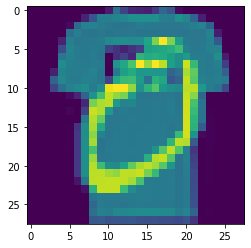

In [5]:
from matplotlib import pyplot as plt
plt.imshow(x_training[1]);

In [6]:
print(x_training[1])

[[0.         0.         0.         0.         0.         0.00392157
  0.         0.         0.         0.         0.16078432 0.7372549
  0.40392157 0.21176471 0.1882353  0.16862746 0.34117648 0.65882355
  0.52156866 0.0627451  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.00392157 0.         0.
  0.         0.19215687 0.53333336 0.85882354 0.84705883 0.89411765
  0.9254902  1.         1.         1.         1.         0.8509804
  0.84313726 0.99607843 0.90588236 0.627451   0.1764706  0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.05490196
  0.6901961  0.87058824 0.8784314  0.83137256 0.79607844 0.7764706
  0.76862746 0.78431374 0.84313726 0.8        0.7921569  0.7882353
  0.7882353  0.7882353  0.81960785 0.85490197 0.8784314  0.6431373
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.7372549
  0.8

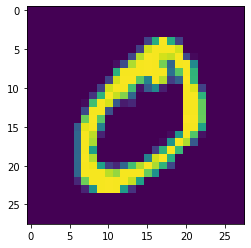

In [7]:
plt.imshow(y_labels[1]);

In [8]:
import tensorflow as tf;
from tensorflow import keras; 

In [9]:
from sklearn.model_selection import train_test_split
X_train_full, X_test, y_train_full, y_test=train_test_split(x_training, y_labels, test_size=.3, random_state = 42)

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

In [10]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [11]:

tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Reshape((28, 28, 1), input_shape=(28, 28)),
    keras.layers.Conv2D(1, kernel_size=18, padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=4),
    keras.layers.Flatten(),
    keras.layers.Dense(11, activation="relu"),
])
denoising_encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 1)         325       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 1)           0         
_________________________________________________________________
flatten (Flatten)            (None, 49)                0         
_________________________________________________________________
dense (Dense)                (None, 11)                550       
Total params: 875
Trainable params: 875
Non-trainable params: 0
_________________________________________________________________


In [12]:
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(14*14 * 1, activation="relu", input_shape=[11]),
    keras.layers.Reshape([14, 14, 1]),
    keras.layers.Conv2DTranspose(filters=1, kernel_size=18, strides=2,
                                 padding="same", activation="sigmoid")
])
denoising_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 196)               2352      
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 1)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 28, 28, 1)         325       
Total params: 2,677
Trainable params: 2,677
Non-trainable params: 0
_________________________________________________________________


In [13]:
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 11)                875       
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         2677      
Total params: 3,552
Trainable params: 3,552
Non-trainable params: 0
_________________________________________________________________


In [14]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("model4.h5",
                                                save_best_only=True)
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(),
                     metrics=["mse"])
history = denoising_ae.fit(X_train, y_train, epochs=40,
                           validation_data=(X_valid, y_valid), batch_size = 64, callbacks=[checkpoint_cb])

Epoch 1/40
579/579 [==============================] - 3s 5ms/step - loss: 0.2779 - mse: 0.0708 - val_loss: 0.2261 - val_mse: 0.0546
Epoch 2/40
579/579 [==============================] - 3s 4ms/step - loss: 0.2105 - mse: 0.0491 - val_loss: 0.1997 - val_mse: 0.0455
Epoch 3/40
579/579 [==============================] - 2s 4ms/step - loss: 0.1929 - mse: 0.0431 - val_loss: 0.1915 - val_mse: 0.0428
Epoch 4/40
579/579 [==============================] - 3s 4ms/step - loss: 0.1865 - mse: 0.0410 - val_loss: 0.1845 - val_mse: 0.0405
Epoch 5/40
579/579 [==============================] - 3s 4ms/step - loss: 0.1831 - mse: 0.0399 - val_loss: 0.1810 - val_mse: 0.0393
Epoch 6/40
579/579 [==============================] - 3s 4ms/step - loss: 0.1808 - mse: 0.0392 - val_loss: 0.1804 - val_mse: 0.0393
Epoch 7/40
579/579 [==============================] - 3s 5ms/step - loss: 0.1790 - mse: 0.0387 - val_loss: 0.1785 - val_mse: 0.0386
Epoch 8/40
579/579 [==============================] - 3s 5ms/step - loss: 0.

In [15]:
model = keras.models.load_model("model4.h5") #Rollback to best mode

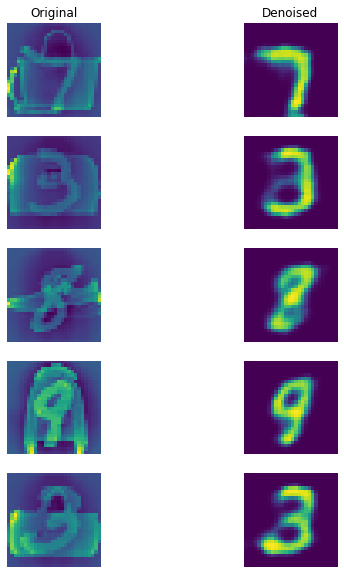

In [16]:
n_images = 5
new_images = X_test[:n_images]
new_images_denoised = model.predict(new_images)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")
plt.show()